In [1]:
import os
import wandb
import torch
import scipy.io
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

from sklearn.metrics import classification_report

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

mnist_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)

## Task 4.1 - Data visualization and Preprocessing

## Task 4.1.1 - Graph on label distribution

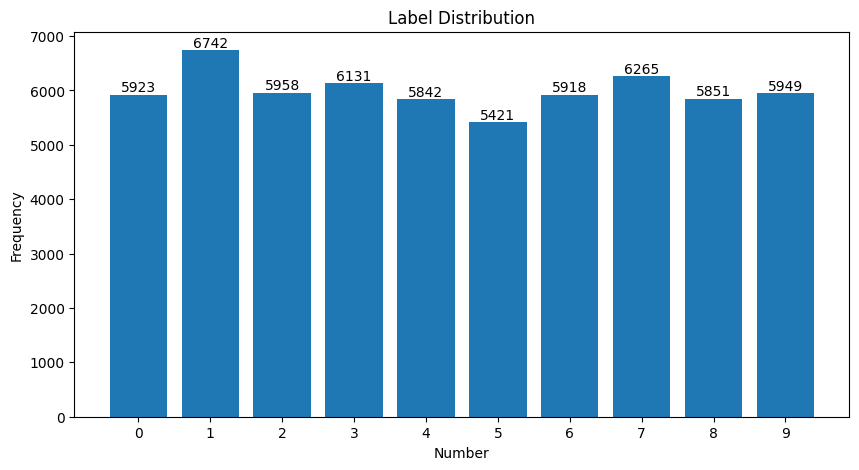

In [3]:
label_distribution = np.zeros(10, dtype=int)
for i in range(10):
    class_indices = mnist_data.targets == i
    label_distribution[i] = len(mnist_data.targets[class_indices])

plt.figure(figsize=(10, 5))
label_bar = plt.bar(range(10), label_distribution, width=0.8)
plt.bar_label(label_bar, label_distribution)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()

## Task 4.1.2 - Visualize some samples from each class

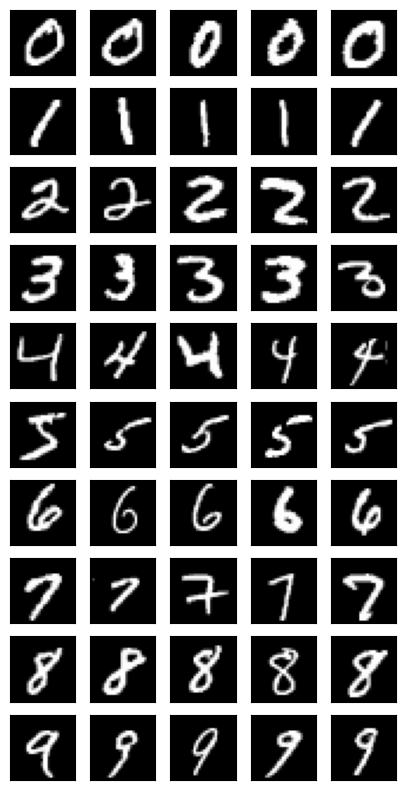

In [4]:
num_samples = 5

fig, ax = plt.subplots(10, num_samples, figsize=(num_samples, 10))

for i in range(10):
    class_indices = mnist_data.targets == i
    class_images = mnist_data.data[class_indices]

    for j in range(num_samples):
        ax[i, j].imshow(class_images[j], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.show()

## Task 4.1.3 - Imbalance in dataset

In [5]:
label_df = pd.DataFrame({'Class': range(1, 11), 'Frequency': label_distribution})
label_df = label_df.sort_values(by='Frequency')
display(label_df.style.hide(axis=0))

Class,Frequency
6,5421
5,5842
9,5851
7,5918
1,5923
10,5949
3,5958
4,6131
8,6265
2,6742


### As we can see there is imbalance in the dataset. There is a difference of more than 1000 images between the class `6` and the class `2`

## Task 4.1.4 - Train-Val-Test split of dataset

In [6]:
train_size = int(0.75 * len(mnist_data))
validation_size = len(mnist_data) - train_size

mnist_train, mnist_val = torch.utils.data.random_split(mnist_data, [train_size, validation_size], generator=torch.Generator().manual_seed(0))
mnist_test             = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

## Task 4.2 - Model Building

## Task 4.2.1, 4.2.2, 4.2.3 - CNN Model with specifications

In [7]:
# CNN for MNIST Classification
# 2 convolutional layers each with ReLU activation and subsequent max pooling, followed by a dropout and a fully-connected layer with softmax activation, optimized using the Adam optimizer and trained with the cross-entropy loss function.
class CNN(nn.Module):
    def __init__(self, lr=0.001, batch_size=64, kernel_size=3, stride=2, num_epochs=10, dropout_rate=0.2, padding=1):
        super(CNN, self).__init__()
        self.lr           = lr
        self.batch_size   = batch_size
        self.kernel_size  = kernel_size
        self.stride       = stride
        self.num_epochs   = num_epochs
        self.dropout_rate = dropout_rate if dropout_rate is not None else 0
        self.padding      = padding

        self.conv1     = nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.out_dim1  = int((28 + 2*self.padding - self.kernel_size)/self.stride + 1)
        self.out_pool1 = int(self.out_dim1 / 2)

        self.conv2     = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.out_dim2  = int((self.out_pool1 + 2*self.padding - self.kernel_size)/self.stride + 1)
        self.out_pool2 = int(self.out_dim2 / 2)

        self.relu      = nn.ReLU()
        self.pool      = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout   = nn.Dropout(self.dropout_rate)
        self.fc        = nn.Linear(in_features=32 * self.out_pool2 * self.out_pool2, out_features=10)
        self.softmax   = nn.Softmax(dim=1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.loss      = nn.CrossEntropyLoss()

    def forward(self, X, feature_map=False):
        X = self.conv1(X)
        X = self.relu(X)
        X = self.pool(X)

        X = self.conv2(X)
        X = self.relu(X)
        X = self.pool(X)

        X_feature = X

        X = X.view(-1, 32 * self.out_pool2 * self.out_pool2)

        X = self.dropout(X)
        X = self.fc(X)
        X = self.softmax(X)

        if feature_map is True:
            return X, X_feature
        else:
            return X
    
    def train_CNN(self, train_data, val_data, progress=True):
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=self.batch_size, shuffle=True)
        val_loader   = torch.utils.data.DataLoader(dataset=val_data,   batch_size=self.batch_size, shuffle=False)

        train_loss        = []
        val_loss          = []
        pred_train_labels = []
        true_train_labels = []
        pred_val_labels   = []
        true_val_labels   = []

        for epoch in range(self.num_epochs):
            self.train()
            epoch_train_loss = 0

            for X, y in train_loader:
                self.optimizer.zero_grad()
                
                y_hat = self.forward(X)
                loss  = self.loss(y_hat, y)
                loss.backward()
                
                self.optimizer.step()
                
                epoch_train_loss += loss.item()

                if epoch == self.num_epochs - 1:
                    pred_train_labels += torch.max(y_hat, 1)[1].tolist()
                    true_train_labels += y.tolist()

            epoch_train_loss /= len(train_loader)
            train_loss.append(epoch_train_loss)

            self.eval()
            epoch_val_loss = 0

            for X, y in val_loader:
                y_hat           = self.forward(X)
                loss            = self.loss(y_hat, y)
                epoch_val_loss += loss.item()

                if epoch == self.num_epochs - 1:
                    pred_val_labels += torch.max(y_hat, 1)[1].tolist()
                    true_val_labels += y.tolist()

            epoch_val_loss /= len(val_loader)
            val_loss.append(epoch_val_loss)

            if progress is True:
                print(f'Epoch {epoch + 1} / {self.num_epochs} ----- Train Loss: {epoch_train_loss} ----- Val Loss: {epoch_val_loss}')

        return train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels
    
    def test_CNN(self, test_data):
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=self.batch_size, shuffle=False)

        self.eval()
        test_loss = 0
        pred_labels = []
        true_labels = []

        for X, y in test_loader:
            y_hat     = self.forward(X)
            loss      = self.loss(y_hat, y)
            test_loss += loss.item()

            pred_labels += torch.max(y_hat, 1)[1].tolist()
            true_labels += y.tolist()

        test_loss /= len(test_loader)

        print(f'Test Loss: {test_loss}')

        return test_loss, pred_labels, true_labels

## Task 4.2.5 - Training and val losses

In [8]:
# Train the model
cnn = CNN()
train_loss, val_loss, _, _, _, _ = cnn.train_CNN(mnist_train, mnist_val)

Epoch 1 / 10 ----- Train Loss: 1.7681455366652121 ----- Val Loss: 1.6178952420011479
Epoch 2 / 10 ----- Train Loss: 1.5741930504075505 ----- Val Loss: 1.5200723343707145
Epoch 3 / 10 ----- Train Loss: 1.5295025286349384 ----- Val Loss: 1.5077325237558243
Epoch 4 / 10 ----- Train Loss: 1.5186410488730127 ----- Val Loss: 1.5051011937729857
Epoch 5 / 10 ----- Train Loss: 1.5133683016015724 ----- Val Loss: 1.4993669347560152
Epoch 6 / 10 ----- Train Loss: 1.508881988511844 ----- Val Loss: 1.4947974007180396
Epoch 7 / 10 ----- Train Loss: 1.50543126700954 ----- Val Loss: 1.4934660343413657
Epoch 8 / 10 ----- Train Loss: 1.5037000805816867 ----- Val Loss: 1.492160886906563
Epoch 9 / 10 ----- Train Loss: 1.5013348643075337 ----- Val Loss: 1.4944184039501434
Epoch 10 / 10 ----- Train Loss: 1.4998654995790937 ----- Val Loss: 1.488698568749935


## Task 4.3 - Hyperparameter Tuning and Evaluation

In [ ]:
learning_rates = [0.01, 0.005, 0.001]
batch_sizes    = [32, 64]
kernel_sizes   = [2, 3]
strides        = [1, 2]
epochs         = [5, 10, 15]
dropout_rates  = [0.2, 0.5]

sweep_config = {
    'method': 'grid',
    'metric': {'goal': 'maximise', 'name': 'val_acc'},
    'parameters': {
        'lr': {'values': learning_rates},
        'epochs': {'values': epochs},
        'batch_size': {'values': batch_sizes},
        'kernel_size': {'values': kernel_sizes},
        'stride': {'values': strides},
        'dropout_rate': {'values': dropout_rates}
    }
}

hyper_param_df = pd.DataFrame(columns=['lr', 'epochs', 'batch_size', 'kernel_size', 'stride', 'dropout_rate', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'per_class_acc', 'no_drop_acc'])

## Task 4.3.1, 4.3.3 - Hyperparameter Tuning and Metric logging

In [ ]:
# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_CNN_Hyperparameters'
# run_num = 1

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run 1_{run_num}')

#     lr, epochs, batch_size, kernel_size, stride, dropout_rate = wandb.config.lr, wandb.config.epochs, wandb.config.batch_size, wandb.config.kernel_size, wandb.config.stride, wandb.config.dropout_rate

#     print(f"Run {run_num}/144 - Learning Rate: {lr} - Epochs: {epochs} - Batch Size: {batch_size} - Kernel Size: {kernel_size} - Stride: {stride} - Dropout Rate: {dropout_rate}")
#     print()

#     cnn = CNN(lr=lr, batch_size=batch_size, kernel_size=kernel_size, stride=stride, num_epochs=epochs, dropout_rate=dropout_rate)
#     train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels = cnn.train_CNN(mnist_train, mnist_val, progress=False)

#     cnn_no_dropout = CNN(lr=lr, batch_size=batch_size, kernel_size=kernel_size, stride=stride, num_epochs=epochs, dropout_rate=None)
#     _, _, _, _, pred_val_labels_no_dropout, true_val_labels_no_dropout = cnn_no_dropout.train_CNN(mnist_train, mnist_val, progress=False)

#     train_acc   = np.sum(np.array(pred_train_labels) == np.array(true_train_labels)) / len(pred_train_labels)
#     val_acc     = np.sum(np.array(pred_val_labels) == np.array(true_val_labels)) / len(pred_val_labels)
#     no_drop_acc = np.sum(np.array(pred_val_labels_no_dropout) == np.array(true_val_labels_no_dropout)) / len(pred_val_labels_no_dropout)

#     per_class_acc = np.zeros(10)
#     for i in range(10):
#         class_indices = np.array(true_val_labels) == i
#         class_pred    = np.array(pred_val_labels)[class_indices]

#         per_class_acc[i] = np.sum(class_pred == i) / len(class_pred)

#     hyper_param_df.loc[len(hyper_param_df)] = [lr, epochs, batch_size, kernel_size, stride, dropout_rate, train_loss[-1], val_loss[-1], train_acc, val_acc, per_class_acc, no_drop_acc]

#     wandb.log({'lr': lr, 'epochs': epochs, 'batch_size': batch_size, 'kernel_size': kernel_size, 'stride': stride, 'dropout_rate': dropout_rate, 'train_loss': train_loss[-1], 'val_loss': val_loss[-1], 'train_acc': train_acc, 'val_acc': val_acc, 'per_class_acc': per_class_acc, 'no_drop_acc': no_drop_acc, 'confusion_matrix': wandb.plot.confusion_matrix(probs=None, y_true=true_val_labels, preds=pred_val_labels, class_names=[str(i) for i in range(10)])})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()
# hyper_param_df.to_csv("./Data/4.3.csv")

## Task 4.3.2 - Dropout v/s No Dropout

In [56]:
metrics_df = pd.read_csv("./Data/4.3.csv")
metrics_df = metrics_df.drop(columns=["Name", "Agent", "State", "Notes", "User", "Tags", "Created", "Runtime", "Sweep"])

# Put the per_class_acc column at the last
metrics_df = metrics_df[["lr", "epochs", "batch_size", "kernel_size", "stride", "dropout_rate", "train_loss", "val_loss", "train_acc", "val_acc", "no_drop_acc", "per_class_acc"]]
metrics_df = metrics_df.sort_values(by='val_acc', ascending=False)

display(metrics_df)

,lr,epochs,batch_size,kernel_size,stride,dropout_rate,train_loss,val_loss,train_acc,val_acc,no_drop_acc,per_class_acc
19,0.001,15,64,3,1,0.2,1.471965,1.473741,0.989467,0.987733,0.985533,"[0.9934895833333334,0.9940898345153664,0.98415..."
91,0.001,15,32,3,1,0.2,1.472485,1.475014,0.988867,0.986600,0.986200,"[0.9921875,0.9875886524822696,0.99104683195592..."
103,0.001,10,32,3,1,0.2,1.475393,1.474955,0.985844,0.986200,0.985533,"[0.9934895833333334,0.991725768321513,0.988292..."
97,0.001,15,32,2,1,0.2,1.476747,1.475328,0.984756,0.985800,0.984800,"[0.9921875,0.9875886524822696,0.98553719008264..."
55,0.001,15,32,3,1,0.5,1.481465,1.475570,0.979711,0.985733,0.986200,"[0.9928385416666666,0.9929078014184396,0.97520..."
...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.010,5,32,2,1,0.2,1.716157,1.714274,0.744822,0.746667,0.729000,"[0,0.9781323877068558,0.993801652892562,0.9042..."
107,0.010,10,32,3,1,0.2,1.820563,1.789749,0.640622,0.671333,0.096800,"[0.9388020833333334,0.9810874704491724,0,0.940..."
83,0.010,5,32,3,1,0.5,1.915971,1.879548,0.545067,0.581533,0.659267,"[0.99609375,0.952127659574468,0,0,0.9183813443..."
95,0.010,15,32,3,1,0.2,2.358383,2.360937,0.102822,0.100267,0.096800,"[0,0,0,1,0,0,0,0,0,0]"


- As we can see, in most of the cases, the validation accuracy is higher whenever there is dropout
- The dropout mechanism ensures that the model does not overfit and hence helps in better generalization of the model
- So, the model performs better when there is dropout in most cases
- Hence, we observe the consistent trend where there is better performance with dropout
- Dropout is extremely helpful in models with huge number of parameters where there is inherent risk of extreme overfitting

## Task 4.4 - Model Evaluation and Analysis

## Task 4.4.1 - Metrics on test dataset

In [23]:
best_CNN = CNN(lr=0.001, batch_size=32, kernel_size=2, stride=1, num_epochs=5, dropout_rate=0.2)
best_CNN.train_CNN(mnist_train, mnist_val)

# Test the model
test_loss, pred_labels, true_labels = best_CNN.test_CNN(mnist_test)

test_acc = np.sum(np.array(pred_labels) == np.array(true_labels)) / len(pred_labels)

per_class_acc = np.zeros(10)

for i in range(10):
    class_indices = np.array(true_labels) == i
    class_pred    = np.array(pred_labels)[class_indices]

    per_class_acc[i] = np.sum(class_pred == i) / len(class_pred)

print()
print(f'Test Accuracy: {test_acc}')
print()
print(f'Per Class Accuracy: {per_class_acc}')
print()
print(classification_report(true_labels, pred_labels, target_names=[str(i) for i in range(10)]))

Epoch 1 / 5 ----- Train Loss: 1.5801039806222272 ----- Val Loss: 1.5053101071416697
Epoch 2 / 5 ----- Train Loss: 1.504288281882665 ----- Val Loss: 1.4951165192671168
Epoch 3 / 5 ----- Train Loss: 1.4947428263580875 ----- Val Loss: 1.4867557437180965
Epoch 4 / 5 ----- Train Loss: 1.4886784208693569 ----- Val Loss: 1.4873270889335095
Epoch 5 / 5 ----- Train Loss: 1.485627964954471 ----- Val Loss: 1.48472811367466
Test Loss: 1.482539269489983
Test Accuracy: 0.9793
Per Class Accuracy: [0.99081633 0.98590308 0.98546512 0.96138614 0.9898167  0.98318386
 0.9697286  0.97276265 0.98767967 0.96630327]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.95      0.99      0.97      1032
           3       0.99      0.96      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.

## Task 4.4.2 - Confusion matrix

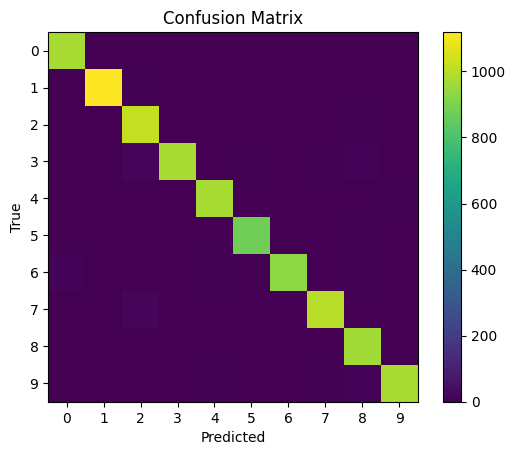

In [27]:
confusion_matrix = np.zeros((10, 10), dtype=int)

for i in range(len(true_labels)):
    confusion_matrix[true_labels[i]][pred_labels[i]] += 1

plt.figure()
plt.imshow(confusion_matrix)
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

## Task 4.4.3 - Wrong prediction analysis

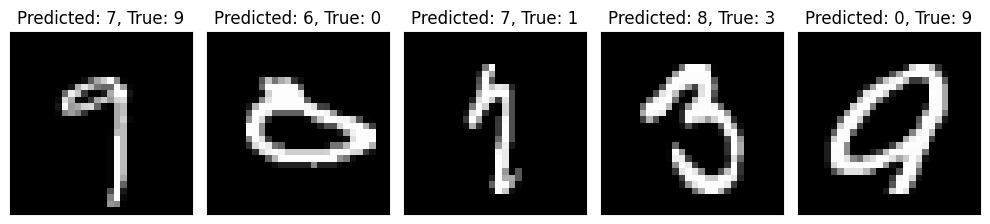

In [51]:
wrong_indices = np.where(np.array(pred_labels) != np.array(true_labels))[0]

num_samples = 5

np.random.seed(6)
wrong_indices = np.random.choice(wrong_indices, num_samples, replace=False)

fig, ax = plt.subplots(1, num_samples, figsize=(10, 10))

for i in range(num_samples):
    ax[i].imshow(mnist_test.data[wrong_indices[i]], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f'Predicted: {pred_labels[wrong_indices[i]]}, True: {true_labels[wrong_indices[i]]}')

plt.tight_layout()
plt.show()

### As we can see above, the misclassified samples are those which are written in such a way that is similar to some other digits as well. The circle in `9` is so small that it seems like `7`. The circle in another `9` is so big that the number seems like `0` and so on.

## Task 4.5 - Train on Noisy Dataset

In [9]:
noisy_mnist = scipy.io.loadmat("./Data/mnist-with-awgn.mat")

noisy_mnist_train_x = torch.Tensor(noisy_mnist['train_x']).reshape(-1, 1, 28, 28)
noisy_mnist_train_y = torch.argmax(torch.Tensor(noisy_mnist['train_y']), 1)
noisy_mnist_train = torch.utils.data.TensorDataset(noisy_mnist_train_x, noisy_mnist_train_y)

noisy_mnist_test_x = torch.Tensor(noisy_mnist['test_x']).reshape(-1, 1, 28, 28)
noisy_mnist_test_y = torch.argmax(torch.Tensor(noisy_mnist['test_y']), 1)
noisy_mnist_test  = torch.utils.data.TensorDataset(noisy_mnist_test_x,  noisy_mnist_test_y)

In [10]:
train_size      = int(0.75 * len(noisy_mnist_train))
validation_size = len(noisy_mnist_train) - train_size

noisy_mnist_train, noisy_mnist_val = torch.utils.data.random_split(noisy_mnist_train, [train_size, validation_size], generator=torch.Generator().manual_seed(0))

## Task 4.5.1, 4.5.2 - Training on noisy data and train and validation metrics

In [11]:
noisy_cnn = CNN()
noisy_train_loss, noisy_val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels = noisy_cnn.train_CNN(noisy_mnist_train, noisy_mnist_val)

noisy_metrics_df = pd.DataFrame(columns=['Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy'])
noisy_metrics_df.loc[0] = [train_loss[-1], val_loss[-1], np.mean(np.array(pred_train_labels) == np.array(true_train_labels)), np.mean(np.array(pred_val_labels) == np.array(true_val_labels))]
display(noisy_metrics_df.style.hide(axis=0))

Epoch 1 / 10 ----- Train Loss: 2.274001736532558 ----- Val Loss: 2.1330554140375018
Epoch 2 / 10 ----- Train Loss: 2.1047137081623077 ----- Val Loss: 1.9578529155000728
Epoch 3 / 10 ----- Train Loss: 1.9023817576129327 ----- Val Loss: 1.8502844566994525
Epoch 4 / 10 ----- Train Loss: 1.8548248041082511 ----- Val Loss: 1.8315852155076697
Epoch 5 / 10 ----- Train Loss: 1.8306643796915358 ----- Val Loss: 1.753341722995677
Epoch 6 / 10 ----- Train Loss: 1.7755878559229048 ----- Val Loss: 1.7729825070563783
Epoch 7 / 10 ----- Train Loss: 1.765960332006216 ----- Val Loss: 1.7359557374994805
Epoch 8 / 10 ----- Train Loss: 1.754653490063819 ----- Val Loss: 1.7368897138757908
Epoch 9 / 10 ----- Train Loss: 1.7564612801440738 ----- Val Loss: 1.736711318442162
Epoch 10 / 10 ----- Train Loss: 1.7545984888618642 ----- Val Loss: 1.7273135971515736


Train Loss,Val Loss,Train Accuracy,Val Accuracy
1.499865,1.488699,0.706244,0.733200


## Task 4.5.3 - Evaluating model on test data

In [12]:
noisy_test_loss, pred_test_labels, true_test_labels = noisy_cnn.test_CNN(noisy_mnist_test)
print(classification_report(true_test_labels, pred_test_labels, zero_division=0))

Test Loss: 1.7184094737289817
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       980
           1       0.85      0.98      0.91      1135
           2       0.00      0.00      0.00      1032
           3       0.69      0.93      0.79      1010
           4       0.93      0.90      0.91       982
           5       0.93      0.93      0.93       892
           6       0.83      0.96      0.89       958
           7       0.00      0.00      0.00      1028
           8       0.60      0.88      0.71       974
           9       0.49      0.93      0.64      1009

    accuracy                           0.74     10000
   macro avg       0.62      0.75      0.67     10000
weighted avg       0.62      0.74      0.67     10000



## Task 4.6 - AutoEncoders to Save the Day

## Task 4.6.1 - AutoEncoder class implementation

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self, in_features=784, hidden_features=128):
        super(AutoEncoder, self).__init__()
        self.in_features     = in_features
        self.hidden_features = hidden_features

        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=self.hidden_features),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.hidden_features, out_features=self.in_features),
            nn.ReLU()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        self.loss      = nn.MSELoss()

    def forward(self, X):
        X = X.view(-1, self.in_features)

        X = self.encoder(X)
        X = self.decoder(X)

        X = X.view(-1, 1, 28, 28)
        return X

    def train_denoise(self, train_data, num_epochs=10, progress=True):
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)

        train_loss = []

        for epoch in range(num_epochs):
            epoch_train_loss = 0

            for X, _ in train_loader:
                self.optimizer.zero_grad()
                
                y_hat = self.forward(X)
                loss  = self.loss(y_hat, X)
                loss.backward()
                
                self.optimizer.step()
                
                epoch_train_loss += loss.item()

            epoch_train_loss /= len(train_loader)
            train_loss.append(epoch_train_loss)

            if progress is True:
                print(f'Epoch {epoch + 1} / {num_epochs} ----- Train Loss: {epoch_train_loss}')

        return train_loss
    
    def get_denoised_data(self, data):
        data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=1, shuffle=False)
        
        self.eval()
        
        denoised_data = []

        for X, _ in data_loader:
            y_hat = self.forward(X)
            denoised_data.append(torch.tensor(y_hat.tolist()[0][0]))

        return torch.cat(denoised_data, dim=0).reshape(-1, 1, 28, 28)

In [14]:
noisy_mnist = scipy.io.loadmat("./Data/mnist-with-awgn.mat")

noisy_mnist_train_val_x = torch.Tensor(noisy_mnist['train_x']).reshape(-1, 1, 28, 28)
noisy_mnist_train_val_y = torch.argmax(torch.Tensor(noisy_mnist['train_y']), 1)
noisy_mnist_train_val   = torch.utils.data.TensorDataset(noisy_mnist_train_x, noisy_mnist_train_y)

noisy_mnist_test_x = torch.Tensor(noisy_mnist['test_x']).reshape(-1, 1, 28, 28)
noisy_mnist_test_y = torch.argmax(torch.Tensor(noisy_mnist['test_y']), 1)
noisy_mnist_test   = torch.utils.data.TensorDataset(noisy_mnist_test_x,  noisy_mnist_test_y)

In [15]:
train_size      = int(0.75 * len(noisy_mnist_train_val))
validation_size = len(noisy_mnist_train_val) - train_size

noisy_mnist_train, noisy_mnist_val = torch.utils.data.random_split(noisy_mnist_train_val, [train_size, validation_size], generator=torch.Generator().manual_seed(0))

In [16]:
auto_encoder = AutoEncoder(in_features=28*28, hidden_features=128)

auto_encoder_train_loader = torch.utils.data.DataLoader(dataset=noisy_mnist_train, batch_size=64, shuffle=True)

train_loss = auto_encoder.train_denoise(noisy_mnist_train)

Epoch 1 / 10 ----- Train Loss: 3579.8562146967106
Epoch 2 / 10 ----- Train Loss: 2951.92964033647
Epoch 3 / 10 ----- Train Loss: 2870.1875287836247
Epoch 4 / 10 ----- Train Loss: 2833.6817016601562
Epoch 5 / 10 ----- Train Loss: 2813.8708683360705
Epoch 6 / 10 ----- Train Loss: 2802.734452334317
Epoch 7 / 10 ----- Train Loss: 2796.4174471768465
Epoch 8 / 10 ----- Train Loss: 2791.193274758079
Epoch 9 / 10 ----- Train Loss: 2784.8039318431506
Epoch 10 / 10 ----- Train Loss: 2766.7507716092196


In [20]:
denoised_mnist_train_x = auto_encoder.get_denoised_data(noisy_mnist_train)
denoised_mnist_train   = torch.utils.data.TensorDataset(denoised_mnist_train_x, noisy_mnist_train[:][1])

denoised_mnist_val_x = auto_encoder.get_denoised_data(noisy_mnist_val)
denoised_mnist_val   = torch.utils.data.TensorDataset(denoised_mnist_val_x, noisy_mnist_val[:][1])

denoised_mnist_test_x = auto_encoder.get_denoised_data(noisy_mnist_test)
denoised_mnist_test   = torch.utils.data.TensorDataset(denoised_mnist_test_x, noisy_mnist_test[:][1])

## Tasks 4.6.3, 4.6.4 - Train the model using de-noised data and get train and validation metrics

In [21]:
denoised_cnn = CNN()
denoised_train_loss, denoised_val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels = denoised_cnn.train_CNN(denoised_mnist_train, denoised_mnist_val)

noisy_metrics_df = pd.DataFrame(columns=['Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy'])
noisy_metrics_df.loc[0] = [denoised_train_loss[-1], denoised_val_loss[-1], np.mean(np.array(pred_train_labels) == np.array(true_train_labels)), np.mean(np.array(pred_val_labels) == np.array(true_val_labels))]
display(noisy_metrics_df.style.hide(axis=0))

Epoch 1 / 10 ----- Train Loss: 2.2163978061554106 ----- Val Loss: 2.0817569803684317
Epoch 2 / 10 ----- Train Loss: 1.9811078079722144 ----- Val Loss: 1.7896079337343256
Epoch 3 / 10 ----- Train Loss: 1.7639675114981153 ----- Val Loss: 1.7211704888242356
Epoch 4 / 10 ----- Train Loss: 1.7315500666472046 ----- Val Loss: 1.7123628611260273
Epoch 5 / 10 ----- Train Loss: 1.718442545526407 ----- Val Loss: 1.6456422734767833
Epoch 6 / 10 ----- Train Loss: 1.6566965578293258 ----- Val Loss: 1.6396442535075735
Epoch 7 / 10 ----- Train Loss: 1.648591865531423 ----- Val Loss: 1.6229849232004043
Epoch 8 / 10 ----- Train Loss: 1.6445441933518106 ----- Val Loss: 1.6261391827400695
Epoch 9 / 10 ----- Train Loss: 1.6406521807340058 ----- Val Loss: 1.6211257731660884
Epoch 10 / 10 ----- Train Loss: 1.6398522205312143 ----- Val Loss: 1.6214911308694393


Train Loss,Val Loss,Train Accuracy,Val Accuracy
1.639852,1.621491,0.820556,0.839333


## Task 4.6.5 - Evaluating model on Test data

In [22]:
test_loss, pred_test_labels, true_test_labels = denoised_cnn.test_CNN(denoised_mnist_test)
print(classification_report(true_test_labels, pred_test_labels, zero_division=0))

Test Loss: 1.6087256723148808
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       980
           1       0.95      0.99      0.97      1135
           2       0.82      0.96      0.89      1032
           3       0.94      0.93      0.94      1010
           4       0.73      0.96      0.83       982
           5       0.68      0.97      0.80       892
           6       0.00      0.00      0.00       958
           7       0.94      0.94      0.94      1028
           8       0.98      0.83      0.90       974
           9       0.93      0.92      0.93      1009

    accuracy                           0.85     10000
   macro avg       0.78      0.85      0.81     10000
weighted avg       0.78      0.85      0.81     10000



## Task 4.6.6 - Comparision between metrics of model on noisy and non-noisy datasets

| Metric         | Model on noisy dataset | Model with AutoEncoder |
|----------------|------------------------|------------------------|
| Train_Accuracy | 70.62                  | 82.05                  |
| Val_Accuracy   | 73.32                  | 83.93                  |
| Test_Accuracy  | 74                     | 85                     |
| Train_Loss     | 1.50                   | 1.64                   |
| Val_Loss       | 1.49                   | 1.62                   |
| Test_Loss      | 1.72                   | 1.61                   |

- As we can see, there is a clear improvement on accuracies across all splits of the datasets
- All accuracies on train, validation and test splits have increased
- This is mainly because of the denoising action of the autoencoder
- We use the autoencoder to reconstruct our initial data from a lesser number of features
- This is done by forcing the model, here autoencoder, to learn the most important features of the data
- This reduces the chances of the model overfitting to the noise in the data
- Hence, we get better estimates of the model parameters and hence better accuracies